<a href="https://colab.research.google.com/github/makkimaki/pytorch-geometric-tutorial/blob/main/1_pygeometric_tutorial_gettingstarted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Geometricのチュートリアル写経

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00


In [14]:
import torch
import torch_geometric
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt

print(f"{torch.__version__=}")
print(f"{torch_geometric.__version__=}")
print(f"{nx.__version__=}")

torch.__version__='2.2.1+cu121'
torch_geometric.__version__='2.5.3'
nx.__version__='3.3'


<class 'torch_geometric.data.data.Data'>
Data(x=[3, 1], edge_index=[2, 4])


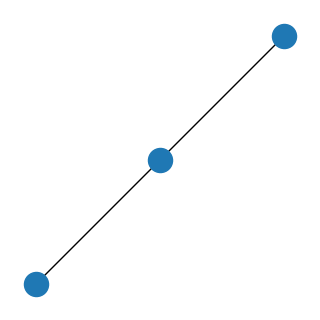

In [27]:
edge_index = torch.tensor([[0, 1],
                            [1, 0],
                            [1, 2],
                            [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
print(type(data))
print(data)

plt.figure(figsize=(3, 3))
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [17]:
#
data.validate(raise_on_error=True)

True

`Data` attributeを使うと色々な機能を利用できる

In [18]:
print(data.keys())

['edge_index', 'x']


In [19]:
print(data["x"])

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [20]:
for key, item in data:
    print(f"{key} found in data")

x found in data
edge_index found in data


In [21]:
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_directed())


3
4
1
False
False
False


## 共通ベンチマークデータセット Common Benchmark Datasets
- Planetoid datasets (Cora, Citeseer, Pubmed)
- TUDatasets
- QM7, QM9 datasets
- FAUST, ModelNet10/40, ShapeNet (3D mesh/point cloud datasets)

In [24]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")
print(dataset)
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

ENZYMES(600)
600
6
3


Data(edge_index=[2, 168], x=[37, 3], y=[1])
<class 'torch_geometric.data.data.Data'>
True


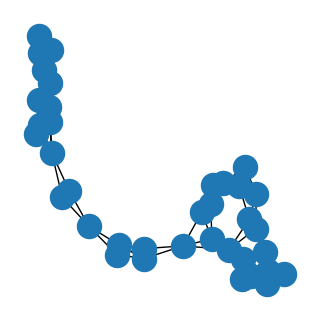

In [29]:
# datasetの最初のグラフは37ノードあり、各ノードは３つのfeaturesを持つ。168/2 =84この無向エッジがあり、グラフは１つのクラスに属している
data = dataset[0]
print(data)
print(type(data))
print(data.is_undirected())

plt.figure(figsize=(3, 3))
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

Data(edge_index=[2, 92], x=[25, 3], y=[1])
True


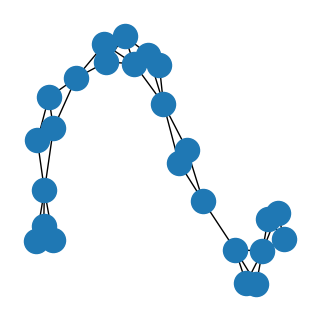

In [33]:
data = dataset[2]
print(data)
print(data.is_undirected())

plt.figure(figsize=(3, 3))
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [31]:
train_dataset = dataset[:540]
test_dataset = dataset[540:]

# dataset = dataset.shuffle()

## ミニバッチ [リンク](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches)
- NNは通常、ミニバッチ形式で学習される
- ミニバッチの構成要素は以下の通り
    - 疎なブロック対角隣接行列(`edge_index`で定義)
    - feature, target行列の連結をノード次元で実施


In [34]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root="/tmp/ENZYMES", name="ENZYMES", use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.num_graphs)

DataBatch(edge_index=[2, 3886], x=[970, 21], y=[32], batch=[970], ptr=[33])
32
DataBatch(edge_index=[2, 3596], x=[948, 21], y=[32], batch=[948], ptr=[33])
32
DataBatch(edge_index=[2, 4556], x=[1178, 21], y=[32], batch=[1178], ptr=[33])
32
DataBatch(edge_index=[2, 4222], x=[1033, 21], y=[32], batch=[1033], ptr=[33])
32
DataBatch(edge_index=[2, 4242], x=[1084, 21], y=[32], batch=[1084], ptr=[33])
32
DataBatch(edge_index=[2, 4628], x=[1236, 21], y=[32], batch=[1236], ptr=[33])
32
DataBatch(edge_index=[2, 4168], x=[1135, 21], y=[32], batch=[1135], ptr=[33])
32
DataBatch(edge_index=[2, 3654], x=[924, 21], y=[32], batch=[924], ptr=[33])
32
DataBatch(edge_index=[2, 3936], x=[1117, 21], y=[32], batch=[1117], ptr=[33])
32
DataBatch(edge_index=[2, 3790], x=[998, 21], y=[32], batch=[998], ptr=[33])
32
DataBatch(edge_index=[2, 4016], x=[1045, 21], y=[32], batch=[1045], ptr=[33])
32
DataBatch(edge_index=[2, 3676], x=[949, 21], y=[32], batch=[949], ptr=[33])
32
DataBatch(edge_index=[2, 3526], x=[889

## Data Transforms
- 画像なら`torchvision`を使う
- PyGの場合は、`Data`オブジェクトを変換するために`torch_geometric.transforms.Compose`を使う
    - `pre_transform`：ディスクに保存する前に実施
    - `transform`：データセットのグラフにアクセスする前に実施

例：ShapeNetデータセット（17000の3D shape point cloudsの各ポイントに16カテゴリから割り当て...?）

In [36]:
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'])

dataset[0]

Extracting /tmp/ShapeNet/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

point cloud datasetからグラフデータセットへ変換できる。この際、データ変換を通じてpoint cloudからnearest neighborグラフを生成する。
- その他の変換は、`torch_geometric.transforms.`にある

In [41]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root="/tmp/ShapeNet", categories=["Airplane"], pre_transform=T.KNNGraph(k=6))

dataset[0]

Data(x=[2518, 3], y=[2518], pos=[2518, 3], category=[1])

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root='/tmp/ShapeNet', categories=['Airplane'],
                    pre_transform=T.KNNGraph(k=6),
                    transform=T.RandomJitter(0.01))

dataset[0]

## Learning methods on Graphs
- GNN実装
- Cora citationデータセット

In [43]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [44]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(),
                               lr=0.01,
                               weight_decay=5e-4)
epoch_list = []
loss_list = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    epoch_list.append(epoch)
    loss_list.append(loss)
    # print(f"{epoch=}, {loss=}")
    optimizer.step()

In [65]:
loss_list = [x.detach() for x in loss_list]

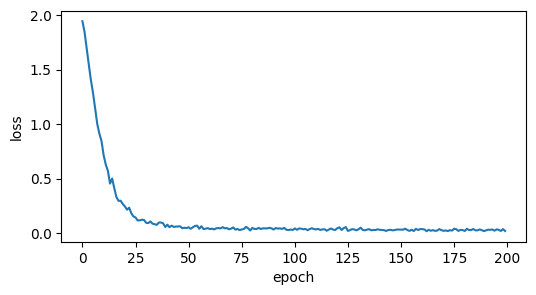

In [68]:
plt.figure(figsize=(6, 3))
plt.plot(epoch_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [69]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()

acc = int(correct) / int(data.test_mask.sum())
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7980
